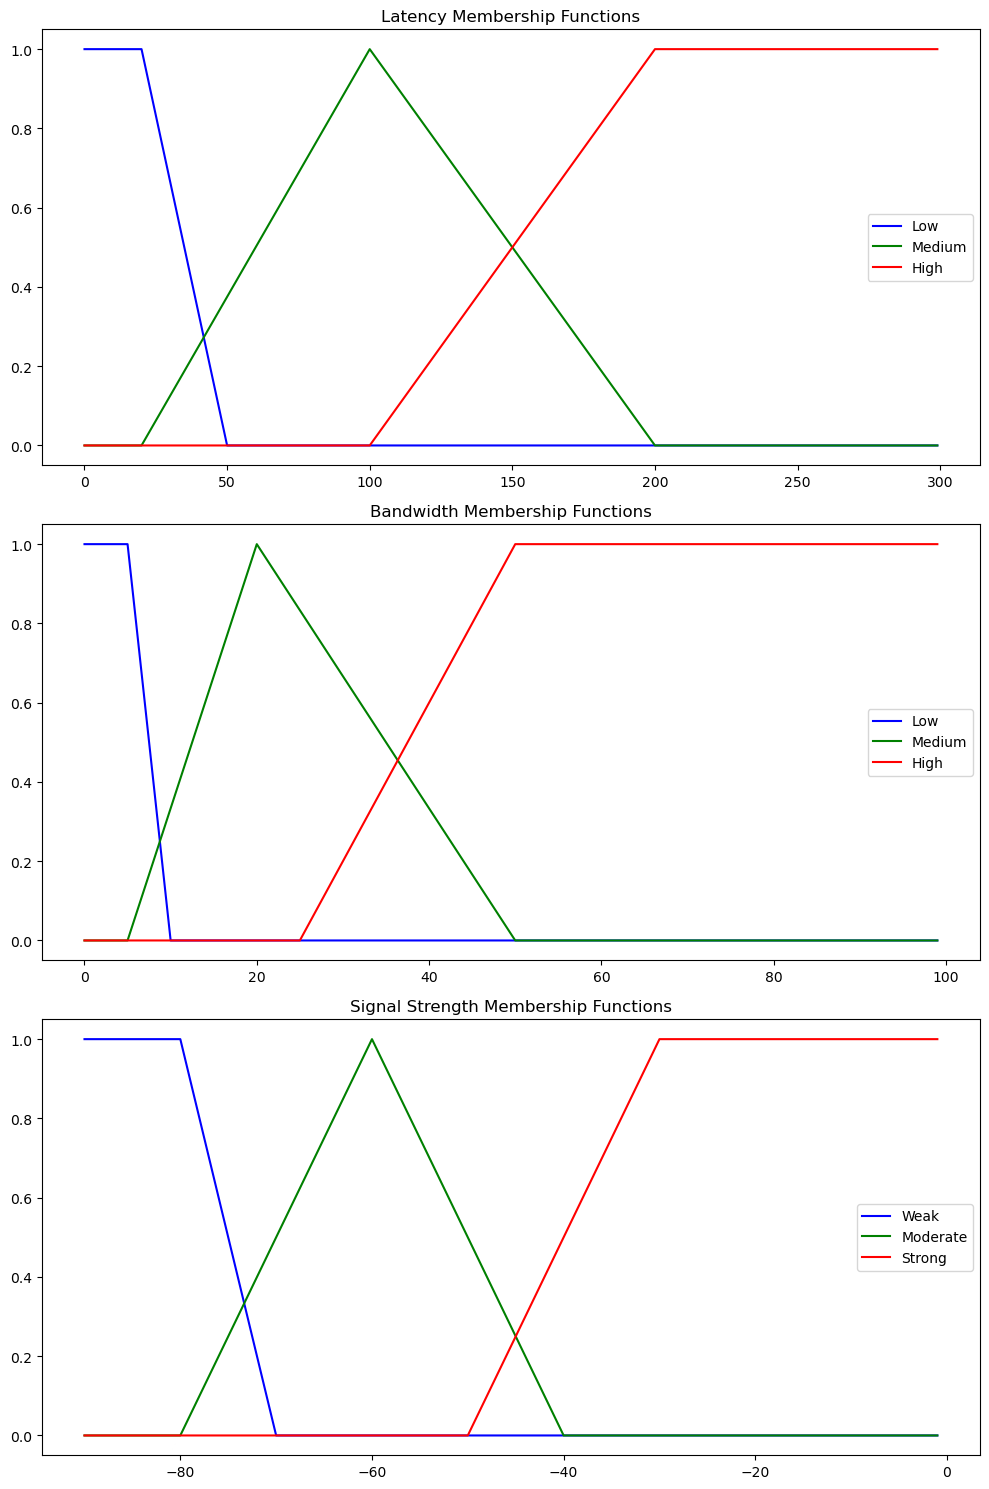

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

latency = np.arange(0, 300, 1)  # Latency range in ms
bandwidth = np.arange(0, 100, 1)  # Bandwidth range in Mbps
signal_strength = np.arange(-90, 0, 1)  # Signal strength range in dBm

latency_low = fuzz.trapmf(latency, [0, 0, 20, 50])
latency_medium = fuzz.trimf(latency, [20, 100, 200])
latency_high = fuzz.trapmf(latency, [100, 200, 300, 300])

bandwidth_low = fuzz.trapmf(bandwidth, [0, 0, 5, 10])
bandwidth_medium = fuzz.trimf(bandwidth, [5, 20, 50])
bandwidth_high = fuzz.trapmf(bandwidth, [25, 50, 100, 100])

signal_weak = fuzz.trapmf(signal_strength, [-90, -90, -80, -70])
signal_moderate = fuzz.trimf(signal_strength, [-80, -60, -40])
signal_strong = fuzz.trapmf(signal_strength, [-50, -30, 0, 0])

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(latency, latency_low, 'b', label='Low')
axs[0].plot(latency, latency_medium, 'g', label='Medium')
axs[0].plot(latency, latency_high, 'r', label='High')
axs[0].set_title('Latency Membership Functions')
axs[0].legend()

axs[1].plot(bandwidth, bandwidth_low, 'b', label='Low')
axs[1].plot(bandwidth, bandwidth_medium, 'g', label='Medium')
axs[1].plot(bandwidth, bandwidth_high, 'r', label='High')
axs[1].set_title('Bandwidth Membership Functions')
axs[1].legend()

axs[2].plot(signal_strength, signal_weak, 'b', label='Weak')
axs[2].plot(signal_strength, signal_moderate, 'g', label='Moderate')
axs[2].plot(signal_strength, signal_strong, 'r', label='Strong')
axs[2].set_title('Signal Strength Membership Functions')
axs[2].legend()
plt.tight_layout()
plt.show()


Initial Neural Network Accuracy: 0.96
 The best solution found:                                                                           
 [0.10554996 0.17555533 1.24773619 1.82402231 0.55382765 0.29178828
 0.77418053 0.37566995 1.28278742]

 Objective function:
 -0.98


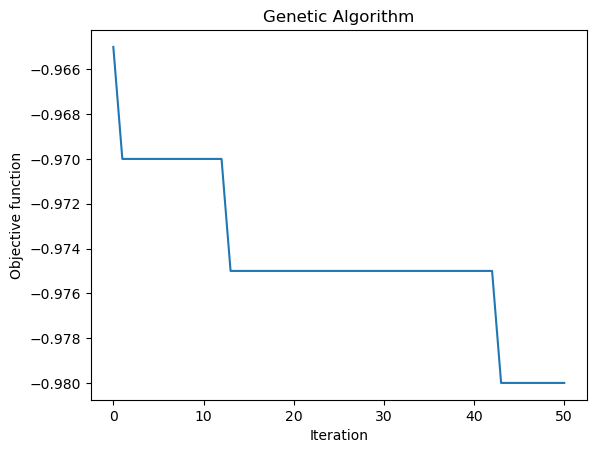

Optimized Neural Network Accuracy: 0.98


In [2]:
import numpy as np
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from geneticalgorithm import geneticalgorithm as ga

np.random.seed(42)
num_samples = 1000
latency = np.random.randint(0, 300, num_samples)
bandwidth = np.random.randint(0, 100, num_samples)
signal_strength = np.random.randint(-90, 0, num_samples)

# Define fuzzy membership functions for a single value
def fuzzify_single_value(value, var_range, membership_functions):
    memberships = [fuzz.interp_membership(var_range, mf, value) for mf in membership_functions]
    return memberships

latency_range = np.arange(0, 300, 1)
bandwidth_range = np.arange(0, 100, 1)
signal_strength_range = np.arange(-90, 0, 1)

latency_mfs = [
    fuzz.trapmf(latency_range, [0, 0, 20, 50]),  # Low
    fuzz.trimf(latency_range, [20, 100, 200]),  # Medium
    fuzz.trapmf(latency_range, [100, 200, 300, 300]),  # High
]

bandwidth_mfs = [
    fuzz.trapmf(bandwidth_range, [0, 0, 5, 10]),  # Low
    fuzz.trimf(bandwidth_range, [5, 20, 50]),  # Medium
    fuzz.trapmf(bandwidth_range, [25, 50, 100, 100]),  # High
]

signal_strength_mfs = [
    fuzz.trapmf(signal_strength_range, [-90, -90, -80, -70]),  # Weak
    fuzz.trimf(signal_strength_range, [-80, -60, -40]),  # Moderate
    fuzz.trapmf(signal_strength_range, [-50, -30, 0, 0]),  # Strong
]

# Generate fuzzy features for the dataset
fuzzy_inputs = np.array([
    fuzzify_single_value(latency[i], latency_range, latency_mfs) +
    fuzzify_single_value(bandwidth[i], bandwidth_range, bandwidth_mfs) +
    fuzzify_single_value(signal_strength[i], signal_strength_range, signal_strength_mfs)
    for i in range(num_samples)
])

# Generate binary labels: 1 for handoff required, 0 otherwise
labels = (latency > 150) | (bandwidth < 20) | (signal_strength < -70)
labels = labels.astype(int)

# Normalize fuzzy inputs
scaler = MinMaxScaler()
fuzzy_inputs = scaler.fit_transform(fuzzy_inputs)

# Split data
X_train, X_test, y_train, y_test = train_test_split(fuzzy_inputs, labels, test_size=0.2, random_state=42)

# Define Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=2000, learning_rate_init=0.001, solver='adam', random_state=42)

# Train Neural Network
nn_model.fit(X_train, y_train)

# Evaluate Neural Network
nn_accuracy = nn_model.score(X_test, y_test)
print(f"Initial Neural Network Accuracy: {nn_accuracy:.2f}")

# Genetic Algorithm for Optimizing Fuzzy Rule Weights
def fitness_function(weights):
    """
    Fitness function for the genetic algorithm.
    Applies weights to the fuzzy features and evaluates the neural network.
    """
    weighted_features = fuzzy_inputs * weights
    X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(weighted_features, labels, test_size=0.2, random_state=42)
    nn_model.fit(X_train_w, y_train_w)
    accuracy = nn_model.score(X_test_w, y_test_w)
    return -accuracy  # Negative because GA minimizes

# Define bounds for weights (0.1 to 2.0 for scaling)
var_bound = np.array([[0.1, 2.0]] * fuzzy_inputs.shape[1])

# Define Genetic Algorithm Model with optimized parameters
ga_model = ga(
    function=fitness_function,
    dimension=fuzzy_inputs.shape[1],
    variable_type='real',
    variable_boundaries=var_bound,
    algorithm_parameters={
        'max_num_iteration': 50,  # Reduce generations for speed
        'population_size': 20,    # Reduce population size
        'mutation_probability': 0.1,
        'elit_ratio': 0.01,
        'parents_portion': 0.3,
        'crossover_probability': 0.5,
        'crossover_type': 'uniform',  # Added crossover type parameter
        'max_iteration_without_improv': None,  
    }
)

# Run Genetic Algorithm
ga_model.run()

# Extract optimized weights
optimized_weights = ga_model.output_dict['variable']

# Evaluate Optimized Model
weighted_fuzzy_inputs = fuzzy_inputs * optimized_weights
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(weighted_fuzzy_inputs, labels, test_size=0.2, random_state=42)
nn_model.fit(X_train_w, y_train_w)
final_accuracy = nn_model.score(X_test_w, y_test_w)

print(f"Optimized Neural Network Accuracy: {final_accuracy:.2f}")


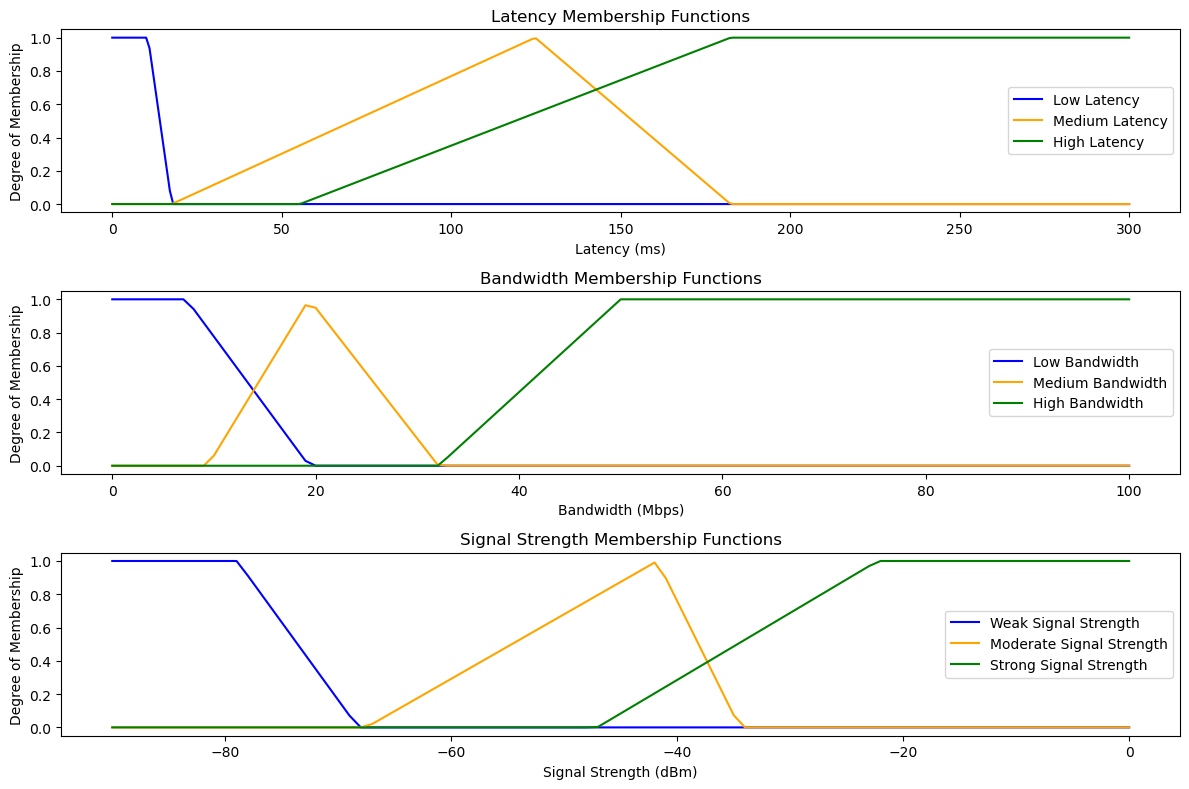

In [3]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Best solution from the Genetic Algorithm
best_solution = [0.10554996, 0.17555533, 1.24773619, 1.82402231, 0.55382765, 
                 0.29178828, 0.77418053, 0.37566995, 1.28278742]

# Define fuzzy input variables
latency_range = np.arange(0, 301, 1)
bandwidth_range = np.arange(0, 101, 1)
signal_strength_range = np.arange(-90, 1, 1)

latency = {'low': fuzz.trapmf(latency_range, [0, 0, best_solution[0] * 100, best_solution[1] * 100]),
           'medium': fuzz.trimf(latency_range, [best_solution[1] * 100, best_solution[2] * 100, best_solution[3] * 100]),
           'high': fuzz.trapmf(latency_range, np.sort([best_solution[3] * 100, best_solution[4] * 100, 300, 300]))}

bandwidth = {'low': fuzz.trapmf(bandwidth_range, [0, 0, best_solution[5] * 25, best_solution[6] * 25]),
             'medium': fuzz.trimf(bandwidth_range, np.sort([best_solution[6] * 25, best_solution[7] * 25, best_solution[8] * 25])),
             'high': fuzz.trapmf(bandwidth_range, [best_solution[8] * 25, 50, 100, 100])}

signal_strength = {'weak': fuzz.trapmf(signal_strength_range, [-90, -90, -80 + best_solution[0] * 10, -70 + best_solution[1] * 10]),
                   'moderate': fuzz.trimf(signal_strength_range, [-80 + best_solution[2] * 10, -60 + best_solution[3] * 10, -40 + best_solution[4] * 10]),
                   'strong': fuzz.trapmf(signal_strength_range, [-50 + best_solution[5] * 10, -30 + best_solution[6] * 10, 0, 0])}

# Plot membership functions
plt.figure(figsize=(12, 8))

# Latency Membership Functions
plt.subplot(3, 1, 1)
plt.plot(latency_range, latency['low'], label='Low Latency', color='blue')
plt.plot(latency_range, latency['medium'], label='Medium Latency', color='orange')
plt.plot(latency_range, latency['high'], label='High Latency', color='green')
plt.title('Latency Membership Functions')
plt.xlabel('Latency (ms)')
plt.ylabel('Degree of Membership')
plt.legend()

# Bandwidth Membership Functions
plt.subplot(3, 1, 2)
plt.plot(bandwidth_range, bandwidth['low'], label='Low Bandwidth', color='blue')
plt.plot(bandwidth_range, bandwidth['medium'], label='Medium Bandwidth', color='orange')
plt.plot(bandwidth_range, bandwidth['high'], label='High Bandwidth', color='green')
plt.title('Bandwidth Membership Functions')
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Degree of Membership')
plt.legend()

# Signal Strength Membership Functions
plt.subplot(3, 1, 3)
plt.plot(signal_strength_range, signal_strength['weak'], label='Weak Signal Strength', color='blue')
plt.plot(signal_strength_range, signal_strength['moderate'], label='Moderate Signal Strength', color='orange')
plt.plot(signal_strength_range, signal_strength['strong'], label='Strong Signal Strength', color='green')
plt.title('Signal Strength Membership Functions')
plt.xlabel('Signal Strength (dBm)')
plt.ylabel('Degree of Membership')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
def make_handoff_decision(latency, bandwidth, signal_strength):
    """Make a handoff decision based on user inputs and fuzzy membership."""
    # Fuzzy membership ranges
    latency_range = np.arange(0, 301, 1)  # Latency: 0 to 300 ms
    bandwidth_range = np.arange(0, 101, 1)  # Bandwidth: 0 to 100 Mbps
    signal_strength_range = np.arange(-90, 1, 1)  # Signal strength: -90 to 0 dBm

    # Fuzzy membership for latency
    latency_low, latency_medium, latency_high = fuzzy_membership(
        latency, latency_range, latency_range, latency_range, "latency"
    )

    # Fuzzy membership for bandwidth
    bandwidth_low, bandwidth_medium, bandwidth_high = fuzzy_membership(
        bandwidth, bandwidth_range, bandwidth_range, bandwidth_range, "bandwidth"
    )

    # Fuzzy membership for signal strength
    signal_strength_low, signal_strength_medium, signal_strength_high = fuzzy_membership(
        signal_strength, signal_strength_range, signal_strength_range, signal_strength_range, "signal_strength"
    )

    # Define rule weights (membership functions aggregated)
    handoff_required = np.fmax(
        np.fmax(
            np.fmin(latency_low, np.fmin(bandwidth_low, signal_strength_low)),
            np.fmin(latency_low, np.fmin(bandwidth_low, signal_strength_medium))
        ),
        np.fmax(
            np.fmin(latency_low, np.fmin(bandwidth_medium, signal_strength_low)),
            np.fmin(latency_medium, np.fmin(bandwidth_low, signal_strength_low))
        )
    )
    
    handoff_maybe = np.fmax(
        np.fmin(latency_low, np.fmin(bandwidth_medium, signal_strength_high)),
        np.fmax(
            np.fmin(latency_medium, np.fmin(bandwidth_high, signal_strength_low)),
            np.fmin(latency_high, np.fmin(bandwidth_medium, signal_strength_medium))
        )
    )
    
    no_handoff = np.fmax(
        np.fmin(latency_low, np.fmin(bandwidth_high, signal_strength_high)),
        np.fmax(
            np.fmin(latency_medium, np.fmin(bandwidth_high, signal_strength_high)),
            np.fmin(latency_high, np.fmin(bandwidth_high, signal_strength_high))
        )
    )

    # Aggregated decision
    if handoff_required > handoff_maybe and handoff_required > no_handoff:
        return "Handoff Required"
    elif handoff_maybe > handoff_required and handoff_maybe > no_handoff:
        return "Handoff Maybe"
    else:
        return "No Handoff"


In [5]:
# Define the fuzzy membership function using the optimized best_solution
def fuzzy_membership(value, low_range, medium_range, high_range, factor):
    """Determine the fuzzy membership degree for low, medium, high categories using optimized parameters."""
    # Latency (in ms)
    if factor == "latency":
        low = fuzz.trapmf(low_range, [0, 0, best_solution[0] * 100, best_solution[1] * 100])  # Adjusted range
        medium = fuzz.trimf(medium_range, [best_solution[1] * 100, best_solution[2] * 100, best_solution[3] * 100])  # Adjusted range
        high = fuzz.trapmf(high_range, sorted([best_solution[3] * 100, best_solution[4] * 100, 300, 300]))  # Adjusted range
    
    # Bandwidth (in Mbps)
    elif factor == "bandwidth":
        low = fuzz.trapmf(low_range, [0, 0, best_solution[5] * 25, best_solution[6] * 25])  # Adjusted range
        medium = fuzz.trimf(medium_range, sorted([best_solution[6] * 25, best_solution[7] * 25, best_solution[8] * 25]))  # Adjusted range
        high = fuzz.trapmf(high_range, [best_solution[8] * 25, 50, 100, 100])  # Adjusted range

    # Signal Strength (in dBm)
    elif factor == "signal_strength":
        low = fuzz.trapmf(low_range, [-90, -90, -80, -70])  # Adjusted weak signal range
        medium = fuzz.trimf(medium_range, [-80, -60, -40])  # Adjusted moderate signal range
        high = fuzz.trapmf(high_range, [-40, -20, 0, 0])  # Adjusted strong signal range

    # Fuzzy membership calculation
    low_value = fuzz.interp_membership(low_range, low, value)
    medium_value = fuzz.interp_membership(medium_range, medium, value)
    high_value = fuzz.interp_membership(high_range, high, value)
    
    return low_value, medium_value, high_value

In [8]:
user_latency = float(input("Enter latency in ms (0-300): "))  # User provides latency
user_bandwidth = float(input("Enter bandwidth in Mbps (0-100): "))  # User provides bandwidth
user_signal_strength = float(input("Enter signal strength in dBm (-90 to 0): "))  # User provides signal strength

# Call fuzzy_membership for each input with the correct factor
latency_low, latency_medium, latency_high = fuzzy_membership(
    user_latency, latency_range, latency_range, latency_range, "latency"
)
bandwidth_low, bandwidth_medium, bandwidth_high = fuzzy_membership(
    user_bandwidth, bandwidth_range, bandwidth_range, bandwidth_range, "bandwidth"
)
signal_strength_low, signal_strength_medium, signal_strength_high = fuzzy_membership(
    user_signal_strength, signal_strength_range, signal_strength_range, signal_strength_range, "signal_strength"
)

# Print fuzzy memberships for debugging
print(f"Latency Low: {latency_low}, Medium: {latency_medium}, High: {latency_high}")
print(f"Bandwidth Low: {bandwidth_low}, Medium: {bandwidth_medium}, High: {bandwidth_high}")
print(f"Signal Strength Low: {signal_strength_low}, Medium: {signal_strength_medium}, High: {signal_strength_high}")

# Use these memberships to make handoff decisions
handoff_decision = make_handoff_decision(user_latency, user_bandwidth, user_signal_strength)
print(f"Handoff Decision: {handoff_decision}")

Enter latency in ms (0-300): 100
Enter bandwidth in Mbps (0-100): 60
Enter signal strength in dBm (-90 to 0): -80
Latency Low: 0.0, Medium: 0.7689417902871349, High: 0.3512629709843057
Bandwidth Low: 0.0, Medium: 0.0, High: 1.0
Signal Strength Low: 1.0, Medium: 0.0, High: 0.0
Handoff Decision: Handoff Maybe


In [56]:
from tabulate import tabulate

# Define the 27 rules
rules = [
    ["Low", "Low", "Low", "Handoff Required"],
    ["Low", "Low", "Medium", "Handoff Required"],
    ["Low", "Low", "High", "Handoff Maybe"],
    ["Low", "Medium", "Low", "Handoff Required"],
    ["Low", "Medium", "Medium", "Handoff Maybe"],
    ["Low", "Medium", "High", "No Handoff"],
    ["Low", "High", "Low", "Handoff Required"],
    ["Low", "High", "Medium", "No Handoff"],
    ["Low", "High", "High", "No Handoff"],
    ["Medium", "Low", "Low", "Handoff Required"],
    ["Medium", "Low", "Medium", "Handoff Required"],
    ["Medium", "Low", "High", "Handoff Maybe"],
    ["Medium", "Medium", "Low", "Handoff Required"],
    ["Medium", "Medium", "Medium", "Handoff Maybe"],
    ["Medium", "Medium", "High", "No Handoff"],
    ["Medium", "High", "Low", "Handoff Maybe"],
    ["Medium", "High", "Medium", "No Handoff"],
    ["Medium", "High", "High", "No Handoff"],
    ["High", "Low", "Low", "Handoff Required"],
    ["High", "Low", "Medium", "Handoff Required"],
    ["High", "Low", "High", "Handoff Required"],
    ["High", "Medium", "Low", "Handoff Required"],
    ["High", "Medium", "Medium", "Handoff Required"],
    ["High", "Medium", "High", "Handoff Maybe"],
    ["High", "High", "Low", "Handoff Maybe"],
    ["High", "High", "Medium", "Handoff Maybe"],
    ["High", "High", "High", "No Handoff"],
]

# Define headers for the table
headers = ["Latency", "Bandwidth", "Signal Strength", "Decision"]

# Generate and display the table
print(tabulate(rules, headers=headers, tablefmt="grid"))


+-----------+-------------+-------------------+------------------+
| Latency   | Bandwidth   | Signal Strength   | Decision         |
+===========+=============+===================+==================+
| Low       | Low         | Low               | Handoff Required |
+-----------+-------------+-------------------+------------------+
| Low       | Low         | Medium            | Handoff Required |
+-----------+-------------+-------------------+------------------+
| Low       | Low         | High              | Handoff Maybe    |
+-----------+-------------+-------------------+------------------+
| Low       | Medium      | Low               | Handoff Required |
+-----------+-------------+-------------------+------------------+
| Low       | Medium      | Medium            | Handoff Maybe    |
+-----------+-------------+-------------------+------------------+
| Low       | Medium      | High              | No Handoff       |
+-----------+-------------+-------------------+---------------